# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
# исследуем данные на предмет пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


> *Первонвчальное иследование показывает, что DataFrame состоит из 8 признаков и 200 строк. Пропущенные данные для всех признаков отсутствуют. Все признаки являются числовыми*

In [4]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


In [5]:
# Произведем поиск дубликатов

dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 0


> *Анализ показывает, что в DataFrame отсутствуют дубликаты*

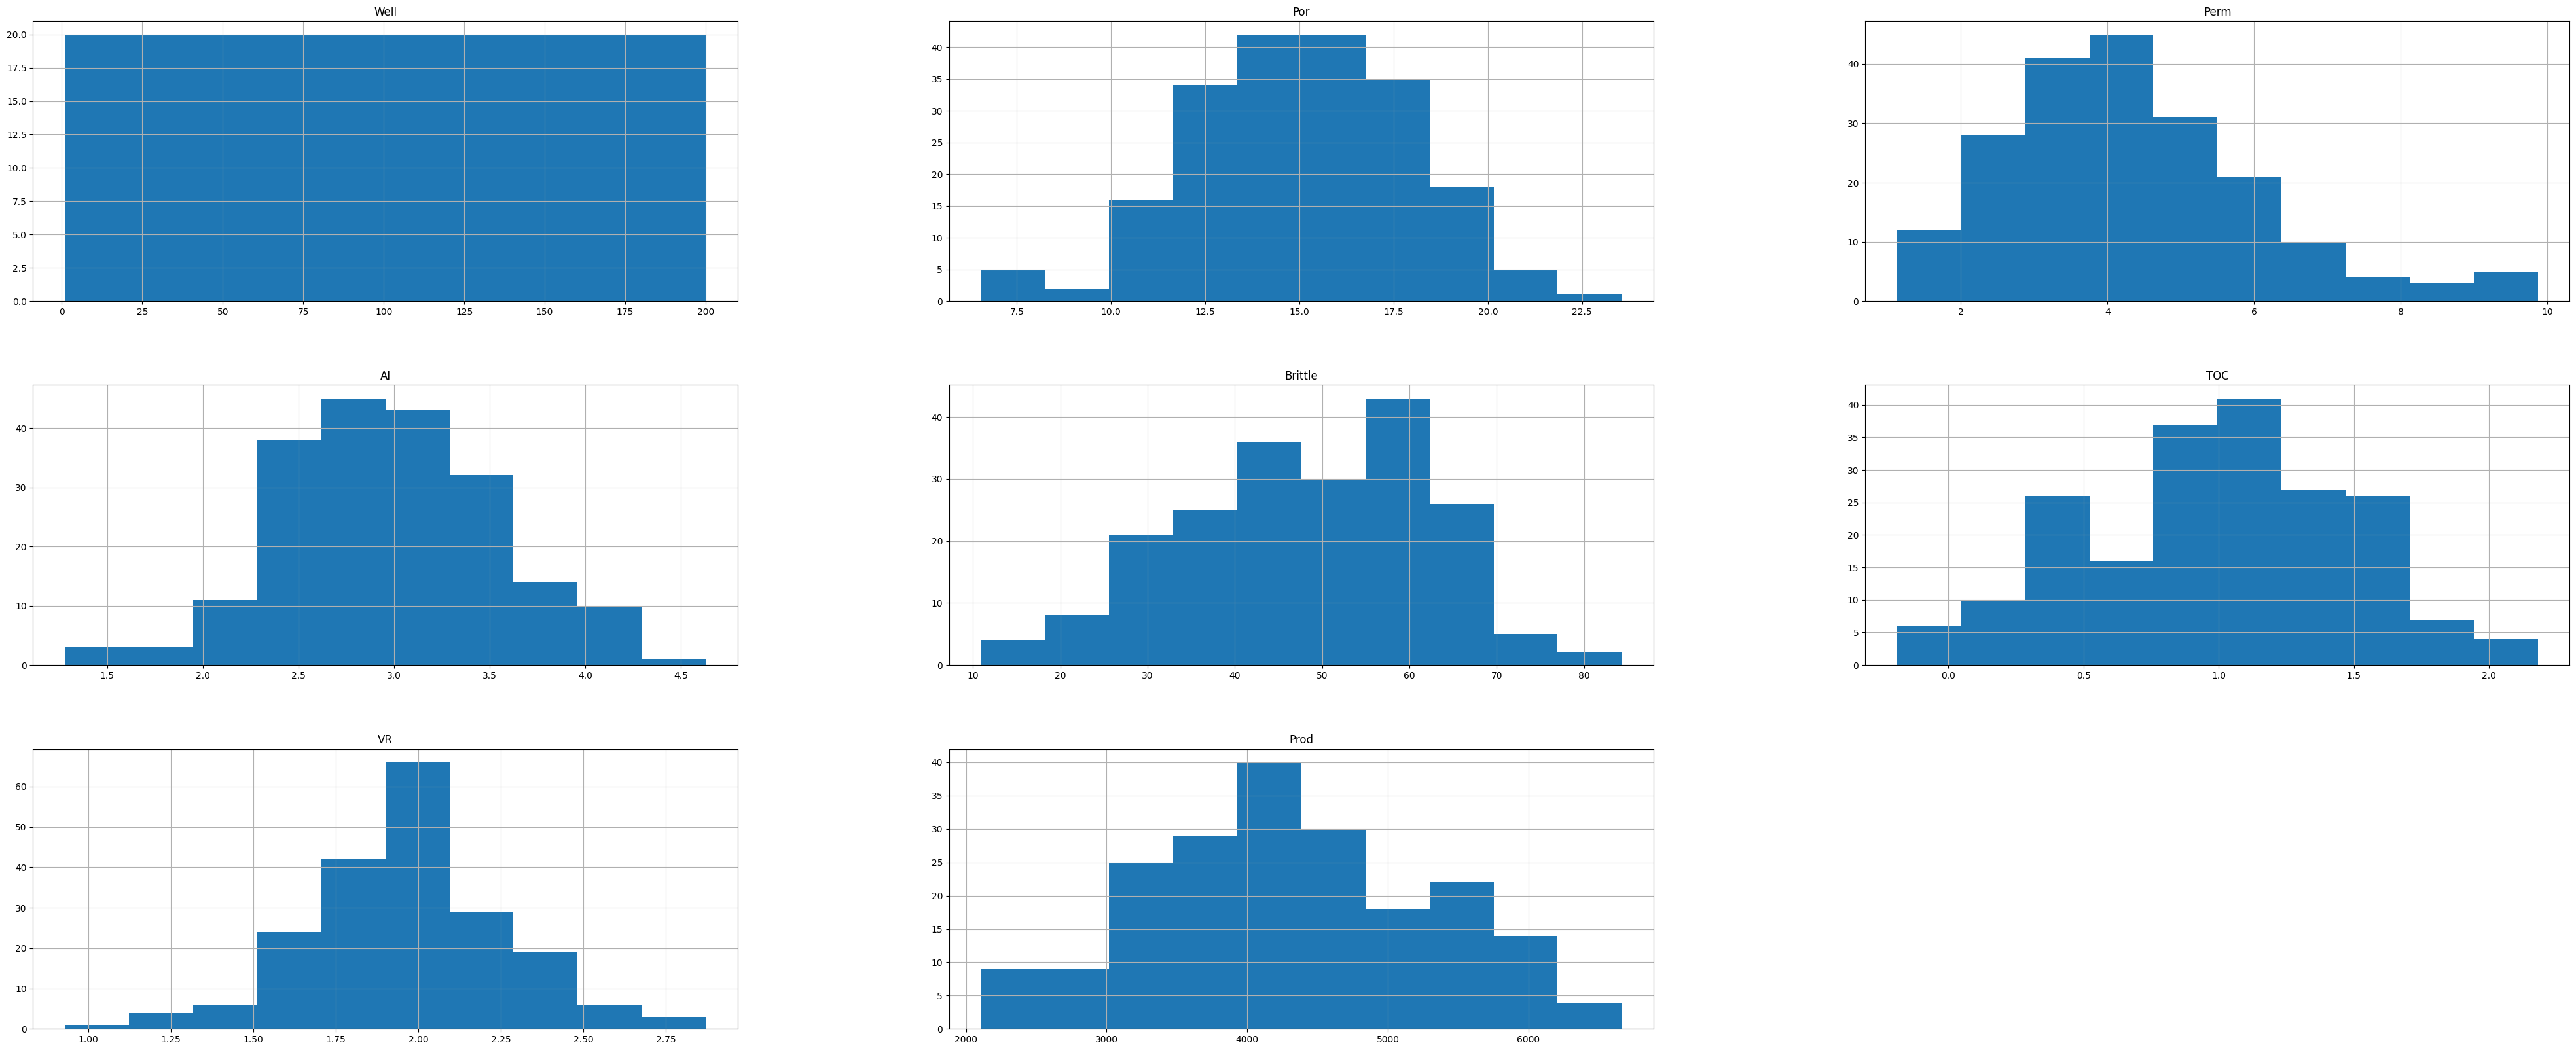

In [6]:
# Построим гистограмму для визуальной оценки признаков на нормальность
data_df = data.copy()

data_df.hist(figsize=(50, 20));

> *Гистограмма показывает, что данные приемущественно распределены по нормальному закону распределения, дополнительных преобразований не требуется*

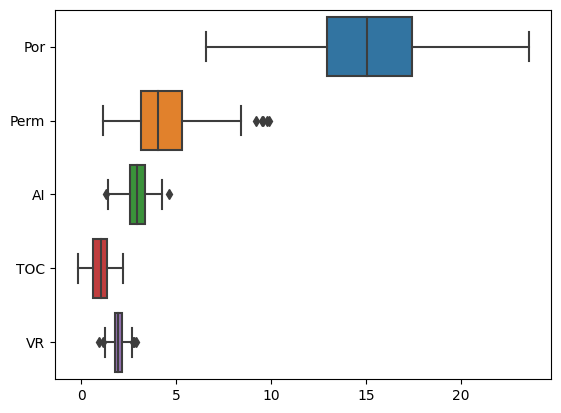

In [7]:
# Построим графики boxplot для визуальной оценки признаков на отсутствие выбросов для признаков 'Por', 'Perm', 'AI', 'TOC', 'VR'

sns.boxplot(data=data_df[['Por', 'Perm', 'AI', 'TOC', 'VR']], orient='h');

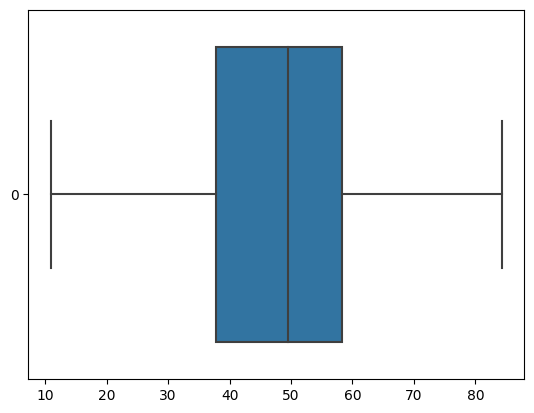

In [8]:
# Отдельно построим график boxplot для визуальной оценки для признака Brittle

sns.boxplot(data=data_df['Brittle'], orient='h');

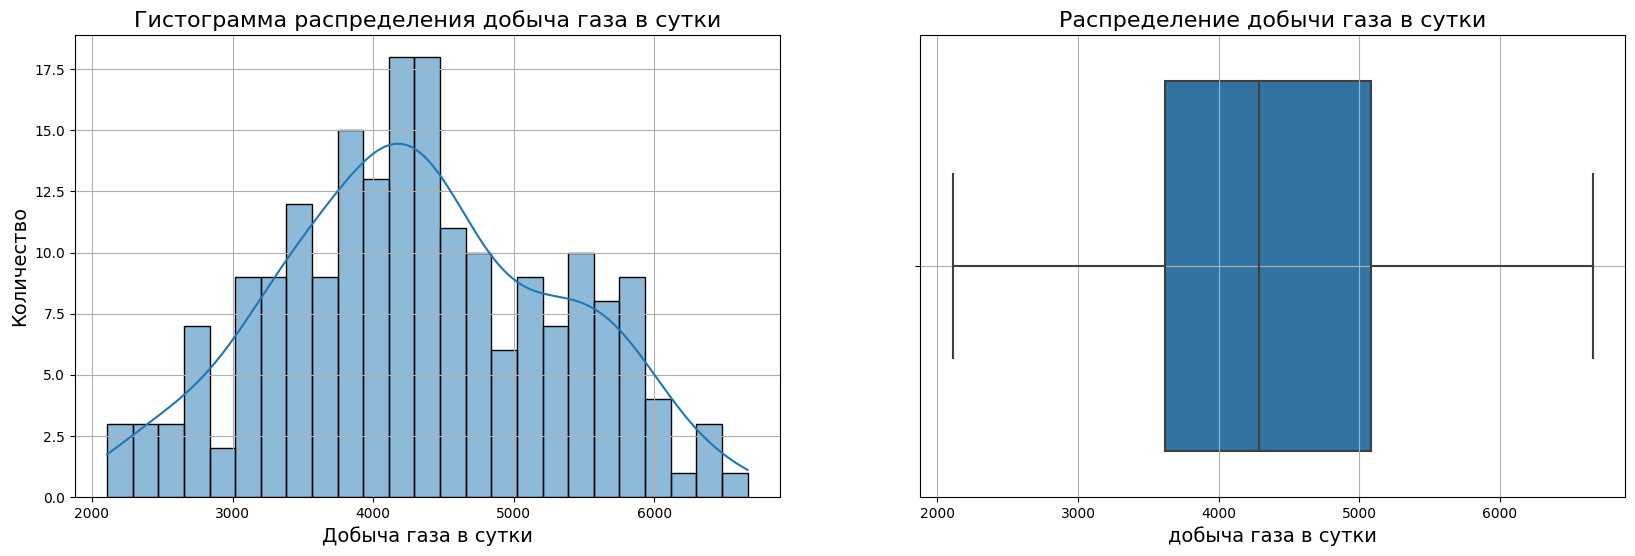

In [9]:
# Построим Гистограмму и boxplot для визуальной оценки целевого для признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
histplot = sns.histplot(
    data=data_df,
    x='Prod',
    bins=25,
    kde=True,
    ax=axes[0]
)
histplot.set_title('Гистограмма распределения добыча газа в сутки', fontsize=16);
histplot.set_xlabel('Добыча газа в сутки', fontsize=14);
histplot.set_ylabel('Количество', fontsize=14);
histplot.grid()

boxplot = sns.boxplot(
    data=data_df,
    x='Prod',
    orient='h',
    ax=axes[1]
)
boxplot.set_title('Распределение добычи газа в сутки', fontsize=16);
boxplot.set_xlabel('добыча газа в сутки', fontsize=14);
boxplot.grid()

> *Коробчатые диаграммы показывают, что в признаках 'Perm', 'AI', 'VR' присутствуют выбросы, не будем удалять выбросы, т.к не предусмотрено заданием*

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
# Построим корреляционную матрицу факторов
data_df.corr()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


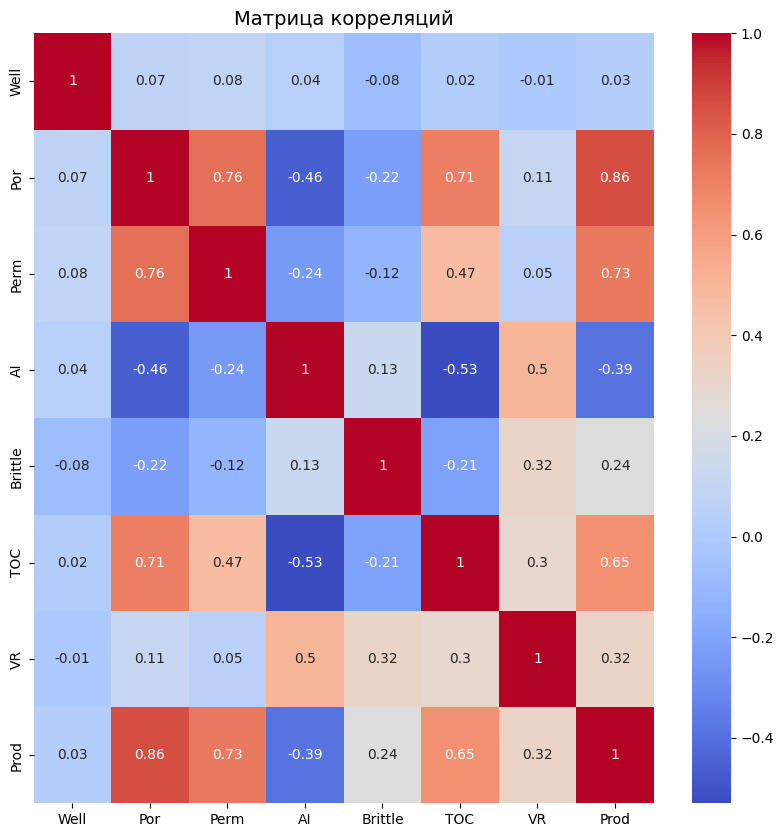

In [11]:
# Визуализируем полученную матрицу с помощью тепловой карты 

fig = plt.figure(figsize=(10, 10))

heatmap = sns.heatmap(round(data_df.corr(method='pearson'), 2), annot = True, cmap= 'coolwarm')
heatmap.set_title('Матрица корреляций', fontsize=14);

> *Факторы Por и Perm имеют сильную связь и более остальных коррелируют с целевой переменной. Признак Well показывает отсутствие связи или очень слабую связь в том числе с целевой переменной, может быть удален(не удаляем, т.к не предусмотрено заданием)* 

In [12]:
# Вычислим ранг и определитель полученной матрицы корреляций

print("Rank:",np.linalg.matrix_rank(data.corr()))
print("Detector:", round(np.linalg.det(data.corr()), 4))

Rank: 8
Detector: 0.0007


> *Матрица получилась размером 8x8, а её ранг равен 8, означает, что чистая коллинеарность отсутствует. Матрица является плохообусловленной, т.к. определитель близок к нулю. Вероятно присутствует скрытая мультиколлинеарность. Для борьба с плохо определёнными (близкими к вырожденным и вырожденными) матрицами рекомендуется использовать метод сингулярного разложения (SVD)*

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [13]:
x = (data_df.drop(['Prod'], axis=1)).values
x = pd.DataFrame(np.column_stack((np.ones(data.shape[0]), x)), columns=['Ones']+list(data.columns[:-1]))
y = data_df[['Prod']]

In [14]:
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(x.T@x)@x.T@y
w_hat.index=x.columns
round(w_hat)

,Prod
Ones,-1232.0
Well,0.0
Por,230.0
Perm,116.0
AI,-365.0
Brittle,25.0
TOC,-78.0
VR,785.0


> *Коэффициент Well получился равен нулю, означает, что данный коэффициент не оказывает влияние и его можно удалить из расчета. Дополнительно коэффициент Ones имеет слишком большое значение в отличие от остальных коэффициенто,возможно требуется стандартизация*

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [15]:
#Параметры предложенной скважины
dict_prod={ 
    'Well': 106.0, 
    'Por': 15.32, 
    'Perm': 3.71, 
    'AI': 3.29, 
    'Brittle': 55.99, 
    'TOC': 1.35, 
    'VR': 2.42 
}

#Рассчитаем абсолютную ошибку построенного прогноза для предложенной скважины
Prod_new = w_hat.iloc[0][0]
for i in dict_prod:
    Prod_new = Prod_new + w_hat.loc[i]*dict_prod[i]
    
MAE_new_prod = round((Prod_new[0] - 4748.315024) , 6)
print('Выработка газа для скважины со заданными параметрами будет:', round(Prod_new[0]), 'миллионов кубических футов газа в день.')
print(f'Абсолютная ошибка MAE построенного прогноза для предложенной скважины составляет:{MAE_new_prod} миллионов кубических футов газа в день.')

Выработка газа для скважины со заданными параметрами будет: 4723 миллионов кубических футов газа в день.
Абсолютная ошибка MAE построенного прогноза для предложенной скважины составляет:-25.25097 миллионов кубических футов газа в день.


In [16]:
#Построим прогноз выработки газа для всех скважин из обучающего набора данных
x_temp = x.copy()

x_temp['y_pred'] = w_hat.iloc[0][0]
for i in x.columns[1:]: 
    x_temp['y_pred'] = x_temp['y_pred'] + w_hat.loc[i][0]*x[i]
y_pred=x_temp['y_pred']

from sklearn import metrics

#Рассчитываем MAE
print('MAE score: {:.3f} миллиона кубических футов газа в день'.format(metrics.mean_absolute_error(y, y_pred)))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))

MAE score: 153.623 миллиона кубических футов газа в день
MAPE score: 3.628 %


> *Абсолютная ошибка MAE построенного прогноза для предложенной скважины составляет:-25.25097 миллиона кубических футов газа в день, что является хорошим результатом. Метрика MAE использована, т.к. ее удобно интерпретировать и она имеряется в тех же единицах, что и целевой признак. Несильно искажается при наличии выбросов, а в данном случае условие задачи не предусматривает очистку от выбросов. Метрика MAPE использована, т.к. ее легко интерпретировать и используется в задачах, где неизвестно, какое значение метрики считать приемлемым. Результат по метрики MAE получился 153 миллиона кубических футов газа в день, что составляет 3.628 % по метрике MAPE,обе метрики показывают хорошее качество модели*

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

> *В факторе TOC — общий органический углерод (%) коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции. Коэффициент корреляции присутствует с положительным знаком, а коэффициент в модели линейной регрессии с отрицательным. Взаимно обратные коэффициенты могут свидетельствовать о наличии мультиколлинеарности<br>
Дополнительно хочу обратить внимание на фактор AI-акустический импеданс, т.к. теория утверждает, что данный фактор с увеличением оказывает положительное влияние, а коэффициенты в модели линейной регрессии и корреляции, стоят с отрицательным знаком.Считаю, что данный вопрос следует более детально разобрать со специалистом в данной области.*

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [17]:
#Удаляем сильно коррелированные между собой факторы
x_corr_cl = x.drop(['Well', 'Por', 'Perm'], axis=1)

#Вычислим OLS-оценку для коэффициентов
w_hat_cl=np.linalg.inv(x_corr_cl.T@x_corr_cl)@x_corr_cl.T@y
w_hat_cl.index=x_corr_cl.columns
display(round(w_hat_cl))

,Prod
Ones,2047.0
AI,-313.0
Brittle,25.0
TOC,1231.0
VR,404.0


In [18]:
#Построим прогноз выработки газа для всех скважин из обучающего набора данных
x_temp = x_corr_cl.copy()

x_temp['y_pred'] = w_hat_cl.iloc[0][0]
for i in x_corr_cl.columns[1:]: 
    x_temp['y_pred'] = x_temp['y_pred'] + w_hat_cl.loc[i][0]*x[i]
y_pred_new=x_temp['y_pred']

#Рассчитываем MAE 
print('MAE score: {:.3f} миллиона кубических футов газа в день'.format(metrics.mean_absolute_error(y, y_pred_new))) 
#Рассчитываем MAPE 
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred_new) * 100))

MAE score: 513.093 миллиона кубических футов газа в день
MAPE score: 12.561 %


> *После удаления трех факторов, качество модели значительно ухудшилось.Результат по метрики MAE получился 513 (в сравнении с предыдущей моделью 153) миллиона кубических футов газа в день, что составляет 12,6 % по метрике MAPE(в сравнении с предыдущей моделью 3,6%),обе метрики показали низкое качество модели.
Предполагаю, что причиной является удаление фактора Perm, у которого корреляция с целевым фактором была близка к средней и составляла 0.73*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [19]:
from sklearn.linear_model import LinearRegression

# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
model.fit(x_corr_cl, y)
print('w_hat:', model.coef_)
y_skl_prediction = model.predict(x_corr_cl)

#Рассчитываем MAE 
print('MAE score: {:.3f} миллиона кубических футов газа в день'.format(metrics.mean_absolute_error(y, y_skl_prediction))) 
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_skl_prediction) * 100))

w_hat: [[2046.85487059 -312.6380811    24.5092627  1230.95105034  403.67112768]]
MAE score: 513.093 миллиона кубических футов газа в день
MAPE score: 12.561 %


> *После удаления факторов, построенная модель линейной регрессии из библиотеки scikit-learn (sklearn) показала такой же результат, что и по методу наименьших квадратов с использованием матричной формулы и библиотеки numpy. Результат по метрики MAE получился 513 миллиона кубических футов газа в день, что составляет 12,6 % по метрике MAPE,обе метрики показали низкое качество модели.*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [20]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [48]:
x_temp = x_corr_cl.copy()

# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
x_scaled = scaler.fit_transform(x_temp)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
x_poly = poly.fit_transform(x_scaled)

# Выводим на экран получившееся количество факторов после генерации полиномиальных признаков
print("Количество факторов после генерации полиномиальных признаков:", x_poly.shape[1])

# создаём модель линейной регрессии
model_poly = LinearRegression(fit_intercept=True)
# вычисляем коэффициенты регрессии
model_poly.fit(x_poly, y)
y_poly_pred = model_poly.predict(x_poly)

#Рассчитываем MAE 
print('MAE score: {:.0f} миллиона кубических футов газа в день'.format(metrics.mean_absolute_error(y, y_poly_pred))) 
#Рассчитываем MAPE
print('MAPE score: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y, y_poly_pred) * 100))

Количество факторов после генерации полиномиальных признаков: 55
MAE score: 694 миллиона кубических футов газа в день
MAPE score: 17.89 %


> *Количество факторов после генерации полиномиальных признаков получилось 55. Значение метрики MAE после генерации полиномиальных признаков составило 694 миллиона кубических футов газа в день, а MAPE 17.89 %. Оба значения получились ниже,  чем  до генерации*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [38]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

param = {'alpha':[0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20]}
lasso = Lasso()
grid_search = GridSearchCV(
    scoring='neg_mean_absolute_percentage_error',
    estimator=lasso,
    param_grid=param,
    cv=5,
    n_jobs=-1
)

grid_search.fit(x_poly, y)
print(grid_search.best_params_)
best_params_lasso = grid_search.best_params_

lasso = Lasso(alpha=grid_search.best_params_['alpha'])
lasso.fit(x_poly, y)

cv_results_lasso = cross_validate(lasso, x_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
lasso_train = round(-cv_results_lasso['train_score'].mean() * 100, 3)
lasso_test = round(-cv_results_lasso['test_score'].mean() * 100, 3)
print('MAPE на тренировочных фолдах: {:.3f}'.format(-cv_results_lasso['train_score'].mean().round(3) * 100))
print('MAPE на валидационных фолдах: {:.3f}'.format(-cv_results_lasso['test_score'].mean().round(3) * 100))

{'alpha': 20}
MAPE на тренировочных фолдах: 11.400
MAPE на валидационных фолдах: 13.200


> *Метрика MAPE на тренировочных и валидационных фолдах показала 11.4 и 13.2 %,  соответственно, что также незначительно хуже, чем до использования полиномиальных признаков (12.6%), но лучше чем после использования полиномиальных признаков (17.9%). 
Метод подбора гиперпаметров GridSearchCV подобрал оптимальное значение alpha = 20, что помогло улучшить значение метрики.
Дополнительно можно отметить, что на тренировочных фолдах, модель показала лучше результаты, чем на  и валидационных фолдах, но из-за незначительной разницы, нельзя утверждать о переобучении модели*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [26]:
from sklearn.linear_model import Ridge

param = {'alpha':[0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20]}
ridge = Ridge()
grid_search = GridSearchCV(
    scoring='neg_mean_absolute_percentage_error',
    estimator=ridge,
    param_grid=param,
    cv=5,
    n_jobs=-1
)

grid_search.fit(x_poly, y)
print(grid_search.best_params_)
best_params_ridge = grid_search.best_params_

ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(x_poly, y)

cv_results_ridge = cross_validate(ridge, x_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
ridge_train = round(-cv_results_ridge['train_score'].mean() * 100, 3)
ridge_test = round(-cv_results_ridge['test_score'].mean() * 100, 3)
print('MAPE на тренировочных фолдах: {:.3f}'.format(-cv_results_ridge['train_score'].mean().round(3) * 100))
print('MAPE на валидационных фолдах: {:.3f}'.format(-cv_results_ridge['test_score'].mean().round(3) * 100))

{'alpha': 5}
MAPE на тренировочных фолдах: 10.900
MAPE на валидационных фолдах: 13.300


> *Метрика MAPE на тренировочных и валидационных фолдах показала 10.9 и 13.3 %, соответственно, что также незначительно хуже, чем до использования полиномиальных признаков (12.6%), но лучше чем после использования полиномиальных признаков (17.9%). Метод подбора гиперпаметров GridSearchCV подобрал оптимальное значение alpha = 5, что помогло улучшить значение метрики.
L1- регуляризация показала чуть лучше результат, чем L2 регуляризация.
Дополнительно можно отметить, что на тренировочных фолдах, модель показала лучше результаты, чем на и валидационных фолдах, но из-за незначительной разницы, нельзя утверждать о переобучении модели*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [39]:
from sklearn.linear_model import ElasticNet

param = {'alpha':[0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20],
        'l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
}
lasso = ElasticNet()
grid_search = GridSearchCV(
    scoring='neg_mean_absolute_percentage_error',
    estimator=lasso,
    param_grid=param,
    cv=5,
    n_jobs=-1
)

grid_search.fit(x_poly, y)
print(grid_search.best_params_)
best_params_ElasticNet = grid_search.best_params_

lasso = ElasticNet(alpha=grid_search.best_params_['alpha'], l1_ratio=grid_search.best_params_['l1_ratio'])
lasso.fit(x_poly, y)

cv_results_ElasticNet = cross_validate(lasso, x_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
lasso_train_ElasticNet = round(-cv_results_ElasticNet['train_score'].mean() * 100, 3)
lasso_test_ElasticNet = round(-cv_results_ElasticNet['test_score'].mean() * 100, 3)
print('MAPE на тренировочных фолдах: {:.3f}'.format(-cv_results_ElasticNet['train_score'].mean().round(3) * 100))
print('MAPE на валидационных фолдах: {:.3f}'.format(-cv_results_ElasticNet['test_score'].mean().round(3) * 100))

{'alpha': 20, 'l1_ratio': 1}
MAPE на тренировочных фолдах: 11.400
MAPE на валидационных фолдах: 13.200


> *Метрика MAPE на тренировочных и валидационных фолдах показала 11.4 и 13.2 %, соответственно, что также незначительно хуже, чем до использования полиномиальных признаков (12.6%), но лучше чем после использования полиномиальных признаков (17.9%). Метод подбора гиперпаметров GridSearchCV подобрал оптимальное значение alpha = 20 и lambda = 1, что помогло улучшить значение метрики на валидационных фолдах до значения 13.2 %. Эластичная сетка показала такой же результат, что L1- регуляризация*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [52]:
model_df = pd.DataFrame({
'Model': ['LinearRegression', 'PolynomialFeatures', 'Lasso', 'Ridge', 'ElasticNet'],
'Hyperparameters': ['Standart', 'degree=3', best_params_lasso, best_params_ridge, best_params_ElasticNet],
'Poly': ['False', 'True', 'True', 'True', 'True'],
'Metric_MAPE_train %': [np.nan, 
                      (metrics.mean_absolute_percentage_error(y, y_poly_pred) * 100),
                      lasso_train, ridge_train, lasso_train_ElasticNet],
'Metric_MAPE_test %': [(metrics.mean_absolute_percentage_error(y, y_skl_prediction) * 100), 
                     (metrics.mean_absolute_percentage_error(y, y_poly_pred) * 100), lasso_test, ridge_test, 
                      lasso_test_ElasticNet]
})
display(model_df)

,Model,Hyperparameters,Poly,Metric_MAPE_train %,Metric_MAPE_test %
0,LinearRegression,Standart,False,NaN,12.561447
1,PolynomialFeatures,degree=3,True,17.892673,17.892673
2,Lasso,{'alpha': 20},True,11.364000,13.217000
3,Ridge,{'alpha': 5},True,10.854000,13.317000
4,ElasticNet,"{'alpha': 20, 'l1_ratio': 1}",True,11.364000,13.217000


> *При использовании полиномиальных признаков третьего порядка, результаты оказались хуже, чем до их исользования, MAPE = 17.89% и MAPE = 12.6% соответственно. Далее при использовании Регуляризации c с подбором гиперпараметров с помощью GridSearchCV, получилось значительно увеличить качество предсказиния модели до значений MAPE(L1) = 13.2%, MAPE(L2) = 13.3%, MAPE(Elastic-Net) = 13.2%. L-1 регуляризация и Elastic-Net показала одинаковые результаты, т.к GridSearchCV подобрал одинаковые значения гиперпараметров ElasticNet {'alpha': 20, 'l1_ratio': 1}, Lasso	{'alpha': 20}. Считаю, что для улучшения качества предсказания модел следует увеличить степень полинома.*